# Import

In [1]:
import torch as tc 
import torch.nn as nn  
import numpy as np
from tqdm import tqdm
from torch.cuda.amp import autocast
import cv2
import os,sys
from glob import glob
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torch.nn.parallel import DataParallel
from dotenv import load_dotenv
import gc

In [2]:
# !python -m pip install --no-index --find-links=/kaggle/input/pip-download-for-segmentation-models-pytorch segmentation-models-pytorch
!pip install --no-index --no-deps /kaggle/input/segmentation-models-pytorch-0-3-3/efficientnet_pytorch-0.7.1-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/segmentation-models-pytorch-0-3-3/pretrainedmodels-0.7.4-py3-none-any.whl
!pip install --no-index --no-deps /kaggle/input/segmentation-models-pytorch-0-3-3/segmentation_models_pytorch-0.3.3-py3-none-any.whl

import segmentation_models_pytorch as smp

Processing /kaggle/input/segmentation-models-pytorch-0-3-3/efficientnet_pytorch-0.7.1-py3-none-any.whl
Processing /kaggle/input/segmentation-models-pytorch-0-3-3/pretrainedmodels-0.7.4-py3-none-any.whl
Processing /kaggle/input/segmentation-models-pytorch-0-3-3/segmentation_models_pytorch-0.3.3-py3-none-any.whl


# config

In [3]:
model_path_i = -1 
class CFG:
# ============== model CFG =============
    model_name = 'Unet'
    backbone = 'se_resnext50_32x4d'

    in_chans = 1 #5 # 65
    #============== _ CFG =============
    image_size = 1024 #512
    input_size= 1024 #512
    tile_size = image_size
    stride = tile_size // 4
    drop_egde_pixel= 0 # 16 #32
    
    target_size = 1
    chopping_percentile=1e-3
    # ============== fold =============
    valid_id = 1
    batch=24 #128
    th_percentile = 0.00143 #0.00145 #0.00146 #0.00149 #0.00145 # 0.0014 #0.00175 #0.0021
    
    model_path=["/kaggle/input/sennet-se-resnext50-32x4d-zip/se_resnext50_32x4d_310_loss0.08_score0.85_val_loss0.10_val_score0.91_midd_1024.pt",]
    
    print(model_path[model_path_i])


/kaggle/input/sennet-se-resnext50-32x4d-zip/se_resnext50_32x4d_310_loss0.08_score0.85_val_loss0.10_val_score0.91_midd_1024.pt


# Model

In [4]:
model_path_i = -1 
class CFG_2:
# ============== model CFG =============
    model_name = 'Unet'
    backbone = 'tu-gcresnext50ts'

    in_chans = 1 #5 # 65
    #============== _ CFG =============
    image_size = 1024 #512
    input_size= 1024 #512
    tile_size = image_size
    stride = tile_size // 4
    drop_egde_pixel= 0 # 16 #32
    
    target_size = 1
    chopping_percentile=1e-3
    # ============== fold =============
    valid_id = 1
    batch=24 #128
    th_percentile = 0.00143 #0.00145 #0.00146 #0.00149 #0.00145 # 0.0014 #0.00175 #0.0021
        
    model_path = ["/kaggle/input/tu-gcresnext50ts/tu-gcresnext50ts_380_loss0.1685_score0.7487_val_loss0.1646_val_score0.8759_midd_1024.pt", #88.0
                 "/kaggle/input/tu-gcresnext50ts/tu-gc-mixup-2/tu-gcresnext50ts_550_loss0.1520_score0.7687_val_loss0.1480_val_score0.8742_midd_1024.pt",
                ] #88.1
    print(model_path[-1])

/kaggle/input/tu-gcresnext50ts/tu-gc-mixup-2/tu-gcresnext50ts_550_loss0.1520_score0.7687_val_loss0.1480_val_score0.8742_midd_1024.pt


In [5]:
model_path_i = -1 
class CFG_3:
# ============== model CFG =============
    model_name = 'Unet'
    backbone = 'tu-tf_efficientnet_b3'

    in_chans = 1 #5 # 65
    #============== _ CFG =============
    image_size = 1024 #512
    input_size= 1024 #512
    tile_size = image_size
    stride = tile_size // 4
    drop_egde_pixel= 0 # 16 #32
    
    target_size = 1
    chopping_percentile=1e-3
    # ============== fold =============
    valid_id = 1
    batch=24 #128
    th_percentile = 0.00143 #0.00145 #0.00146 #0.00149 #0.00145 # 0.0014 #0.00175 #0.0021
        
    model_path = ["/kaggle/input/tu-tf-efficientnet-b3/ema_2/tu-tf_efficientnet_b3_350_ema_loss0.0992_score0.8231_val_loss0.1807_val_score0.1250_midd_1024.pt"]
    print(model_path[-1])

/kaggle/input/tu-tf-efficientnet-b3/ema_2/tu-tf_efficientnet_b3_350_ema_loss0.0992_score0.8231_val_loss0.1807_val_score0.1250_midd_1024.pt


In [6]:
class CustomModel(nn.Module):
    def __init__(self, CFG, weight=None):
        super().__init__()
        self.CFG = CFG
        self.model = smp.Unet(
            encoder_name=CFG.backbone, 
            encoder_weights=weight,
            in_channels=CFG.in_chans,
            classes=CFG.target_size,
            activation=None,
        )
        self.batch=CFG.batch

    def forward_(self, image,):
        output = self.model(image)
        return output[:,0]
    
    def forward(self,x, num_tta=2):
        #x.shape=(batch,c,h,w)
        x=x.to(tc.float32)
        x=norm_with_clip(x.reshape(-1,*x.shape[2:])).reshape(x.shape)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x,size=(CFG.input_size,CFG.input_size),mode='bilinear',align_corners=True)
        
        shape=x.shape
#         print(shape, num_tta)
        if num_tta > 4:
            x_tmp=[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(4)]
#             print(len(x_tmp))
            flip_axis = [[2], [3], [2, 3]]
            for i in range(4, num_tta):
                x_tmp.append(tc.flip(x, dims=flip_axis[i - 4]))
            x=x_tmp
            del x_tmp
        else:
            x=[tc.rot90(x,k=i,dims=(-2,-1)) for i in range(num_tta)]

        x=tc.cat(x,dim=0)
#         print(x.size())
        with autocast():
            with tc.no_grad():
                x=[self.forward_(x[i*self.batch:(i+1)*self.batch]) for i in range(x.shape[0]//self.batch+1)]
                # batch=64,64...48
#                 x = [x[i*self.batch:(i+1)*self.batch] for i in range(x.shape[0]//self.batch+1)]
                x=tc.cat(x,dim=0)
        x=x.sigmoid()
        
        x=x.reshape(num_tta,shape[0],*shape[2:])
#         print('x.reshape(num_tta,shape[0],*shape[2:])', x.size())
        if num_tta > 4:
            x_rotate=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(4)]
            for i in range(4, num_tta):
                x_rotate.append(tc.flip(x[i].unsqueeze(1), dims=flip_axis[i-4]).squeeze(1))
            x = x_rotate
            del x_rotate
        else:
            x=[tc.rot90(x[i],k=-i,dims=(-2,-1)) for i in range(num_tta)]
        
        x=tc.stack(x,dim=0).mean(0)
        
        if CFG.input_size!=CFG.image_size:
            x=nn.functional.interpolate(x[None],size=(CFG.image_size,CFG.image_size),mode='bilinear',align_corners=True)[0]
        return x


def build_model(weight=None):
    load_dotenv()

    print('model_name', CFG.model_name)
    print('backbone', CFG.backbone)

    model = CustomModel(CFG, weight)

    return model.cuda()

def build_model_2(weight=None):
    load_dotenv()

    print('model_name', CFG_2.model_name)
    print('backbone', CFG_2.backbone)

    model = CustomModel(CFG_2, weight) #CustomModel(CFG_2, weight)

    return model.cuda()



In [7]:
def build_model_3(weight=None):
    load_dotenv()

    print('model_name', CFG_3.model_name)
    print('backbone', CFG_3.backbone)

    model = CustomModel(CFG_3, weight)

    return model.cuda()

# Size

In [8]:
def to_1024(img , image_size = 1024):
    if image_size > img.shape[1]:
       img = np.rot90(img)
       start1 = (CFG.image_size - img.shape[0])//2 
       top =     img[0                    : start1,   0: img.shape[1] ]
       bottom  = img[img.shape[0] -start1 : img.shape[0],   0 : img.shape[1] ]
       img_result = np.concatenate((top,img,bottom ),axis=0)
       img_result = np.rot90(img_result)
       img_result = np.rot90(img_result)
       img_result = np.rot90(img_result)
    else :
       img_result = img
    return img_result

def to_1024_no_rot(img, image_size = 1024):
    if image_size > img.shape[0]:  
       start1 = ( image_size - img.shape[0])//2
       top =     img[0                    : start1,   0: img.shape[1] ]
       bottom  = img[img.shape[0] -start1 : img.shape[0],   0 : img.shape[1] ]
       img_result = np.concatenate((top,img,bottom ),axis=0)
    else: 
       img_result = img
    return img_result

def to_1024_1024(img  , image_size = 1024 ):
     img_result = to_1024(img, image_size )
     return img_result
    
def to_original ( im_after, img, image_size = 1024 ):
    top_ = 0
    left_ = 0
    if (im_after.shape[0] > img.shape[0]):
             top_  = ( image_size - img.shape[0])//2 
    if    (im_after.shape[1] > img.shape[1]) :
             left_  = ( image_size - img.shape[1])//2  
    if (top_>0)or (left_>0) :
             img_result = im_after[top_  : img.shape[0] + top_,   left_: img.shape[1] + left_ ]
    else:
             img_result = im_after
    return img_result  

# Functions

In [9]:
def rle_encode(mask):
    pixel = mask.flatten()
    pixel = np.concatenate([[0], pixel, [0]])
    run = np.where(pixel[1:] != pixel[:-1])[0] + 1
    run[1::2] -= run[::2]
    rle = ' '.join(str(r) for r in run)
    if rle == '':
        rle = '1 0'
    return rle

def min_max_normalization(x:tc.Tensor)->tc.Tensor:
    """input.shape=(batch,f1,...)"""
    shape=x.shape
    if x.ndim>2:
        x=x.reshape(x.shape[0],-1)
    
    min_=x.min(dim=-1,keepdim=True)[0]
    max_=x.max(dim=-1,keepdim=True)[0]
    if min_.mean()==0 and max_.mean()==1:
        return x.reshape(shape)
    
    x=(x-min_)/(max_-min_+1e-9)
    return x.reshape(shape)

def norm_with_clip(x:tc.Tensor,smooth=1e-5):
    dim=list(range(1,x.ndim))
    mean=x.mean(dim=dim,keepdim=True)
    std=x.std(dim=dim,keepdim=True)
    x=(x-mean)/(std+smooth)
    x[x>5]=(x[x>5]-5)*1e-3 +5
    x[x<-3]=(x[x<-3]+3)*1e-3-3
    return x

class Data_loader(Dataset):
    def __init__(self,path,s="/images/"):
        self.paths=glob(path+f"{s}*.tif")
        self.paths.sort()
        self.bool=s=="/labels/"
    
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        img=cv2.imread(self.paths[index],cv2.IMREAD_GRAYSCALE)
        ims = img.shape

        img = to_1024_1024(img , image_size = CFG.image_size )
        
        img=tc.from_numpy(img.copy())
        if self.bool:
            img=img.to(tc.bool)
        else:
            img=img.to(tc.uint8)
        return img, ims

def load_data(path,s):
    data_loader=Data_loader(path,s)
    data_loader=DataLoader(data_loader, batch_size=16, num_workers=2)
    data=[]
    for x, ims in tqdm(data_loader):
        data.append(x)
        ims = (ims[0][0].item(), ims[1][0].item())
        print('load data', ims)
    x=tc.cat(data,dim=0)
    del data
    gc.collect()
    ########################################################################
    TH=x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH:int = np.partition(TH, index)[index]
    x[x>TH]=int(TH)
    ########################################################################
    TH=x.reshape(-1).numpy()
    index = -int(len(TH) * CFG.chopping_percentile)
    TH:int = np.partition(TH, -index)[-index]
    x[x<TH]=int(TH)
    ########################################################################
    #x=(min_max_normalization(x.to(tc.float16))*255).to(tc.uint8)
    return x, ims

class Pipeline_Dataset(Dataset):
    def __init__(self,x,path):
        self.img_paths  = glob(path+"/images/*")
        self.img_paths.sort()
        self.in_chan = CFG.in_chans
        z=tc.zeros(self.in_chan//2,*x.shape[1:],dtype=x.dtype)
        self.x=tc.cat((z,x,z),dim=0)
        
    def __len__(self):
        return self.x.shape[0]-self.in_chan+1
    
    def __getitem__(self, index):
        x  = self.x[index:index+self.in_chan]
        return x,index
    
    def get_mark(self,index):
        id=self.img_paths[index].split("/")[-3:]
        id.pop(1)
        id="_".join(id)
        return id[:-4]
    
    def get_marks(self):
        ids=[]
        for index in range(len(self)):
            ids.append(self.get_mark(index))
        return ids

def add_edge(x:tc.Tensor,edge:int):
    #x=(C,H,W)
    #output=(C,H+2*edge,W+2*edge)
    mean_=int(x.to(tc.float32).mean())
    x=tc.cat([x,tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_],dim=1)
    x=tc.cat([x,tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_],dim=2)
    x=tc.cat([tc.ones([x.shape[0],edge,x.shape[2]],dtype=x.dtype,device=x.device)*mean_,x],dim=1)
    x=tc.cat([tc.ones([x.shape[0],x.shape[1],edge],dtype=x.dtype,device=x.device)*mean_,x],dim=2)
    return x

# Build model(s)

In [10]:
model=build_model()
print(CFG.model_path[ model_path_i])
model.load_state_dict(tc.load(CFG.model_path[ model_path_i ],"cpu"))
model.eval()
model=DataParallel(model)

model_2=build_model_2()
print(CFG_2.model_path[ model_path_i] )
model_2.load_state_dict(tc.load(CFG_2.model_path[ model_path_i ],"cpu"))
model_2.eval()
model_2=DataParallel(model_2)

model_name Unet
backbone se_resnext50_32x4d
/kaggle/input/sennet-se-resnext50-32x4d-zip/se_resnext50_32x4d_310_loss0.08_score0.85_val_loss0.10_val_score0.91_midd_1024.pt
model_name Unet
backbone tu-gcresnext50ts
/kaggle/input/tu-gcresnext50ts/tu-gc-mixup-2/tu-gcresnext50ts_550_loss0.1520_score0.7687_val_loss0.1480_val_score0.8742_midd_1024.pt


In [11]:
model_3=build_model_3()
print(CFG_3.model_path[ model_path_i] )
model_3.load_state_dict(tc.load(CFG_3.model_path[ model_path_i ],"cpu"))
model_3.eval()
model_3=DataParallel(model_3)

model_name Unet
backbone tu-tf_efficientnet_b3
/kaggle/input/tu-tf-efficientnet-b3/ema_2/tu-tf_efficientnet_b3_350_ema_loss0.0992_score0.8231_val_loss0.1807_val_score0.1250_midd_1024.pt


In [12]:
import torch.nn.functional as F

def get_output(debug=False, split_th=750):
    outputs=[]
    tc.cuda.empty_cache()
    gc.collect()
    if debug:
        paths=["/kaggle/input/blood-vessel-segmentation/test/kidney_6"]
#         paths=glob("/kaggle/input/blood-vessel-segmentation/test/*")
#         paths=glob("/kaggle/input/test-kid/tmp_0205/*")
        print(paths)
    else:
        paths=glob("/kaggle/input/blood-vessel-segmentation/test/*")
    outputs=[[],[],[],[],[]]
    idx_pp_cut = []
    for path in paths:
        x, ims =load_data(path,"/images/")
        if x.size()[0] < split_th:
            x_private = x
            print('x_private', x_private.size())
            x_inter = x.size()
            outputs[4] = [x_private, path]
#             x = F.interpolate(x.unsqueeze(1), scale_factor=63.08/50, mode='bilinear', align_corners=True).squeeze(1)
            x = F.interpolate(x.unsqueeze(1), scale_factor=63.08/50, mode='bilinear', align_corners=False).squeeze(1).squeeze(1)
#             x = F.interpolate(x.permute(1,0,2).unsqueeze(1), scale_factor=(63.08/50, 1), mode='bilinear', align_corners=True).squeeze(1).permute(1,0,2)
            print('x_private_inter', x.size())
#         elif debug:
#             print('debug ***', x.size())
#             continue
        else:
            x_inter = x.size()
            
        idx_pp_cut.append(int(x.size()[0]))
        print('skrrrr', ims)
#         labels=tc.zeros_like(x,dtype=tc.uint8)
#         labels=tc.zeros_like(x,dtype=tc.float32)
#         labels=tc.zeros_like((x.size()[0], ims[0], ims[1]),dtype=tc.float32)
        labels=tc.zeros((x.size()[0], x_inter[-2], x_inter[-1]),dtype=tc.float32)
        print('labels', labels.size())

        mark=Pipeline_Dataset(x,path).get_marks()
        ims = [ims for item in mark]
#         aug_list = [0,1,2]
        aug_list = [0]

        for axis in aug_list:
            debug_count=0
            if axis==0:
                x_=x
                labels_=labels
                x_inter_ = x_inter
            elif axis==1:
                x_=x.permute(1,2,0)
                labels_=labels.permute(1,2,0)
                x_inter_ = (x_inter[1], x_inter[2], x_inter[0])
            elif axis==2:
                x_=x.permute(2,0,1)
                labels_=labels.permute(2,0,1)
                x_inter_ = (x_inter[2], x_inter[0], x_inter[1])
            if x.shape[0]==3 and axis!=0:
                break
            dataset=Pipeline_Dataset(x_,path)
            dataloader=DataLoader(dataset,batch_size=1,shuffle=False,num_workers=2)
            shape=dataset.x.shape[-2:]
            x1_list = np.arange(0, shape[0]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
            y1_list = np.arange(0, shape[1]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
            for img,index in tqdm(dataloader):
                #img=(1,C,H,W)
                img=img.to("cuda:0")
                img=add_edge(img[0],CFG.tile_size//2)[None]

                mask_pred = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)
                mask_count = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)

                indexs=[]
                chip=[]
                for y1 in y1_list:
                    for x1 in x1_list:
                        x2 = x1 + CFG.tile_size
                        y2 = y1 + CFG.tile_size
                        indexs.append([x1+CFG.drop_egde_pixel,x2-CFG.drop_egde_pixel,
                                       y1+CFG.drop_egde_pixel,y2-CFG.drop_egde_pixel])
                        chip.append(img[...,x1:x2,y1:y2])
#                 chip_cat = tc.cat(chip)
#                 y_preds = model.forward(chip_cat).to(device=0)
#                 y_preds_2 = model_2.forward(chip_cat).to(device=0)
                if x.size()[0] < split_th:
                    y_preds = model.forward(tc.cat(chip), 6).to(device=0)
                    y_preds_2 = model_2.forward(tc.cat(chip), 6).to(device=0)
                    y_preds.add_(y_preds_2).div_(2)
                    del y_preds_2
                else:
                    y_preds = model_3.forward(tc.cat(chip), 1).to(device=0)
                    
                if CFG.drop_egde_pixel:
                    y_preds=y_preds[...,CFG.drop_egde_pixel:-CFG.drop_egde_pixel,
                                        CFG.drop_egde_pixel:-CFG.drop_egde_pixel]
                for i,(x1,x2,y1,y2) in enumerate(indexs):
                    mask_pred[...,x1:x2, y1:y2] += y_preds[i]
                    mask_count[...,x1:x2, y1:y2] += 1

                mask_pred /= mask_count

                #Rrecover
                mask_pred=mask_pred[...,CFG.tile_size//2:-CFG.tile_size//2,CFG.tile_size//2:-CFG.tile_size//2]
                print('debug1', mask_pred.size())
                if x.size()[0] < split_th:
                    print('x_inter_[1:]', x_inter_[1:])
                    mask_pred = F.interpolate(mask_pred.unsqueeze(1), size=x_inter_[1:], mode='bilinear', align_corners=False).squeeze(1)
                    
                print('debug2', mask_pred.size())

#                 labels_[index]+=(mask_pred[0]*255 /len(aug_list) ).to(tc.uint8).cpu()
#                 mask_pred[0] = 
                labels_[index]+=(mask_pred[0] / len(aug_list) ).cpu()

                tc.cuda.empty_cache()
                gc.collect()
                if debug:
                    debug_count+=1
                    print(debug_count)
                    if debug_count>5:
                        break
            tc.cuda.empty_cache()
            gc.collect()                
        outputs[0].append(labels)
        outputs[1].extend(mark)
        outputs[2].extend(ims)
    outputs[3] = idx_pp_cut
        
    return outputs

In [13]:
def get_extra_output(debug=False, x=None):
    outputs=[]
    tc.cuda.empty_cache()
    gc.collect()
    x, path = x
    outputs=[[],[],[],[],[]]
#     for path in paths:
#         labels=tc.zeros_like(x,dtype=tc.uint8)
    labels=tc.zeros_like(x,dtype=tc.float32)
    aug_list = [0,1,2]
    for axis in aug_list:
        debug_count=0
        if axis==0:
            x_=x
            labels_=labels
        elif axis==1:
            x_=x.permute(1,2,0)
            labels_=labels.permute(1,2,0)
        elif axis==2:
            x_=x.permute(2,0,1)
            labels_=labels.permute(2,0,1)
        if x.shape[0]==3 and axis!=0:
            break
        dataset=Pipeline_Dataset(x_,path)
        dataloader=DataLoader(dataset,batch_size=1,shuffle=False,num_workers=2)
        shape=dataset.x.shape[-2:]
        x1_list = np.arange(0, shape[0]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
        y1_list = np.arange(0, shape[1]+CFG.tile_size-CFG.tile_size+1, CFG.stride)
        for img,index in tqdm(dataloader):
            #img=(1,C,H,W)
            img=img.to("cuda:0")
            img=add_edge(img[0],CFG.tile_size//2)[None]

            mask_pred = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)
            mask_count = tc.zeros_like(img[:,0],dtype=tc.float32,device=img.device)

            indexs=[]
            chip=[]
            for y1 in y1_list:
                for x1 in x1_list:
                    x2 = x1 + CFG.tile_size
                    y2 = y1 + CFG.tile_size
                    indexs.append([x1+CFG.drop_egde_pixel,x2-CFG.drop_egde_pixel,
                                   y1+CFG.drop_egde_pixel,y2-CFG.drop_egde_pixel])
                    chip.append(img[...,x1:x2,y1:y2])
#                 chip_cat = tc.cat(chip)
#                 y_preds = model.forward(chip_cat).to(device=0)
#                 y_preds_2 = model_2.forward(chip_cat).to(device=0)
            y_preds = model.forward(tc.cat(chip), 6).to(device=0)
            y_preds_2 = model_2.forward(tc.cat(chip), 6).to(device=0)
#                 del chip_cat
#                 y_preds = (y_preds + y_preds_2) / 2
            y_preds.add_(y_preds_2)#.div_(2)
            y_preds_3 = model_3.forward(tc.cat(chip), 6).to(device=0)
            y_preds.add_(y_preds_3).div_(3)

            del y_preds_2, y_preds_3

            if CFG.drop_egde_pixel:
                y_preds=y_preds[...,CFG.drop_egde_pixel:-CFG.drop_egde_pixel,
                                    CFG.drop_egde_pixel:-CFG.drop_egde_pixel]
            for i,(x1,x2,y1,y2) in enumerate(indexs):
                mask_pred[...,x1:x2, y1:y2] += y_preds[i]
                mask_count[...,x1:x2, y1:y2] += 1

            mask_pred /= mask_count

            #Rrecover
            mask_pred=mask_pred[...,CFG.tile_size//2:-CFG.tile_size//2,CFG.tile_size//2:-CFG.tile_size//2]

#                 labels_[index]+=(mask_pred[0]*255 /len(aug_list) ).to(tc.uint8).cpu()
            labels_[index]+=(mask_pred[0] /len(aug_list) ).cpu()

            tc.cuda.empty_cache()
            gc.collect()
            if debug:
                debug_count+=1
                print(debug_count)
                if debug_count>5:
                    break
        tc.cuda.empty_cache()
        gc.collect()                
    outputs[0].append(labels)
    return outputs[0]

skrrr11111111111111 (1303, 912)
['/kaggle/input/blood-vessel-segmentation/test/kidney_6']


100%|██████████| 1/1 [00:00<00:00,  4.43it/s]

load data (1303, 912)


x_private torch.Size([3, 1303, 1024])
x_private_inter torch.Size([3, 1643, 1291])
skrrrr (1303, 912)
labels torch.Size([3, 1303, 1024])


  0%|          | 0/3 [00:00<?, ?it/s]

debug1 torch.Size([1, 1643, 1291])
x_inter_[1:] torch.Size([1303, 1024])
debug2 torch.Size([1, 1303, 1024])


 33%|███▎      | 1/3 [00:14<00:28, 14.38s/it]

1
debug1 torch.Size([1, 1643, 1291])
x_inter_[1:] torch.Size([1303, 1024])
debug2 torch.Size([1, 1303, 1024])


 67%|██████▋   | 2/3 [00:26<00:13, 13.30s/it]

2
debug1 torch.Size([1, 1643, 1291])
x_inter_[1:] torch.Size([1303, 1024])
debug2 torch.Size([1, 1303, 1024])


100%|██████████| 3/3 [00:39<00:00, 13.20s/it]

3
torch.Size([3, 1303, 1024])



 33%|███▎      | 1/3 [00:12<00:25, 12.89s/it]

1


 67%|██████▋   | 2/3 [00:25<00:12, 12.86s/it]

2


100%|██████████| 3/3 [00:38<00:00, 12.92s/it]

3


th 153.0
np size (1303, 912)
1


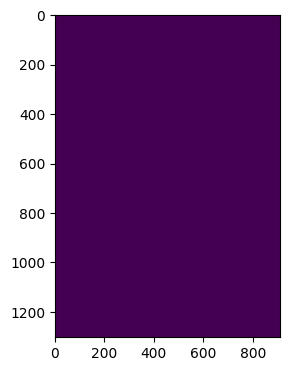

np size (1303, 912)
2


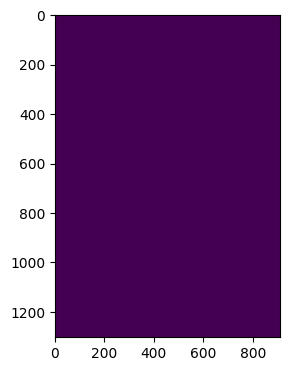

np size (1303, 912)
3


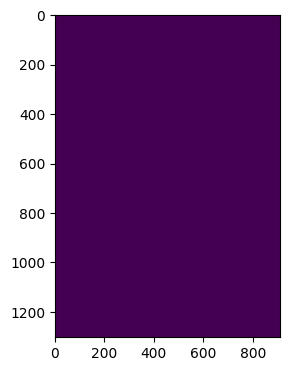

,id,rle
0,kidney_6_0000,1 0
0,kidney_6_0001,1 0
0,kidney_6_0002,1 0


In [14]:
# from concurrent.futures import ProcessPoolExecutor

is_submit=len(glob("/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/*.tif"))!=3

split_th = 750
if not is_submit:
    split_th /= 10
# is_submit=False #True
img=cv2.imread("/kaggle/input/blood-vessel-segmentation/test/kidney_5/images/0001.tif",cv2.IMREAD_GRAYSCALE)
print('skrrr11111111111111', img.shape)
output,ids,ims_list,idx_pp_cut, x_private = get_output(not is_submit, split_th)

if x_private != None:
    print(x_private[0].size())
    model2_path_2 = "/kaggle/input/tu-gcresnext50ts/tu-gcresnext50ts_146_loss0.1513_score0.7666_val_loss0.1252_val_score0.8924_midd_1024.pt/tu-gcresnext50ts_146_loss0.1513_score0.7666_val_loss0.1252_val_score0.8924_midd_1024.pt"
    checkpoint = tc.load(model2_path_2,"cpu")
    new_state_dict_2 = {f"module.{key}": value for key, value in checkpoint.items()}
    model_2.load_state_dict(new_state_dict_2)
    model_2.eval()
#     model_2=DataParallel(model_2)    
    output_x_private_extra = get_extra_output(not is_submit, x_private)
    for idx, item in enumerate(output):
        if item.size()[0] < split_th:
            output[idx] = (255 * (item + output_x_private_extra[0])/2).to(tc.uint8)
        else:
            output[idx] = (255 * item).to(tc.uint8)
        
####################################
# print('idx_pp_cut ', idx_pp_cut)
# TH=[x.flatten().numpy() for x in output]
# # TH=[x.flatten().numpy() for x in output[:idx_pp_cut[0]]]
for x in output:
    if x.size()[0] < 750:
        TH=[x.flatten().numpy()]
        TH=np.concatenate(TH)
        index = -int(len(TH) * CFG.th_percentile)
        TH:int = np.partition(TH, index)[index]
        break
# TH=np.concatenate(TH)
# index = -int(len(TH) * CFG.th_percentile)
# TH:int = np.partition(TH, index)[index]
TH:int = 255 * 0.6

print("th", TH)
# TH = 26

####################################
submission_df=[]
debug_count=0
for index in range(len(ids)):
    id=ids[index]
    ims = ims_list[index]
    img = np.zeros(ims)
    print('np size', img.shape)
    i=0
    for x in output:
        if index>=len(x):
            index-=len(x)
            i+=1
        else:
            break
    mask_pred=(output[i][index]>TH).numpy()
    
    mask_pred2 = to_original ( mask_pred, img, image_size = 1024 )
    mask_pred =  mask_pred2.copy()
    
    ####################################
    if not is_submit:
        debug_count+=1
        print(debug_count)
        plt.subplot(121)
        plt.imshow(mask_pred)
        plt.show()
        if debug_count>100:
            break
        
    rle = rle_encode(mask_pred)
    
    submission_df.append(
        pd.DataFrame(data={
            'id'  : id,
            'rle' : rle,
        },index=[0])
    )

submission_df =pd.concat(submission_df)
# submission_df.to_csv('submission.csv', index=False)
submission_df.head(6)
def is_isolated(_row):
    return (_row["rle"]!='1 0' and _row["prev_rle"]=='1 0' and _row["next_rle"]=='1 0')

def fix_nc_slices(_row):
    if _row["seg_isolated"]:
        _row["rle"] = '1 0'
    return _row

submission_df["prev_rle"] = submission_df.shift(3, fill_value='1 0')["rle"]
submission_df["next_rle"] = submission_df.shift(-3, fill_value='1 0')["rle"]

submission_df["seg_isolated"] = submission_df.apply(is_isolated, axis=1)
submission_df = submission_df.apply(fix_nc_slices, axis=1)

submission_df = submission_df[["id", "rle"]]
submission_df.to_csv('submission.csv', index=False)
submission_df.head(6)